In [29]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import mlflow
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec
from mlflow.types import DataType


import warnings
warnings.filterwarnings("ignore")


In [30]:
wine_data = load_wine()

feature_df=pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
feature_df["label"]=data=wine_data.target

In [31]:
feature_df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [32]:
np.bincount(feature_df["label"])

array([59, 71, 48])

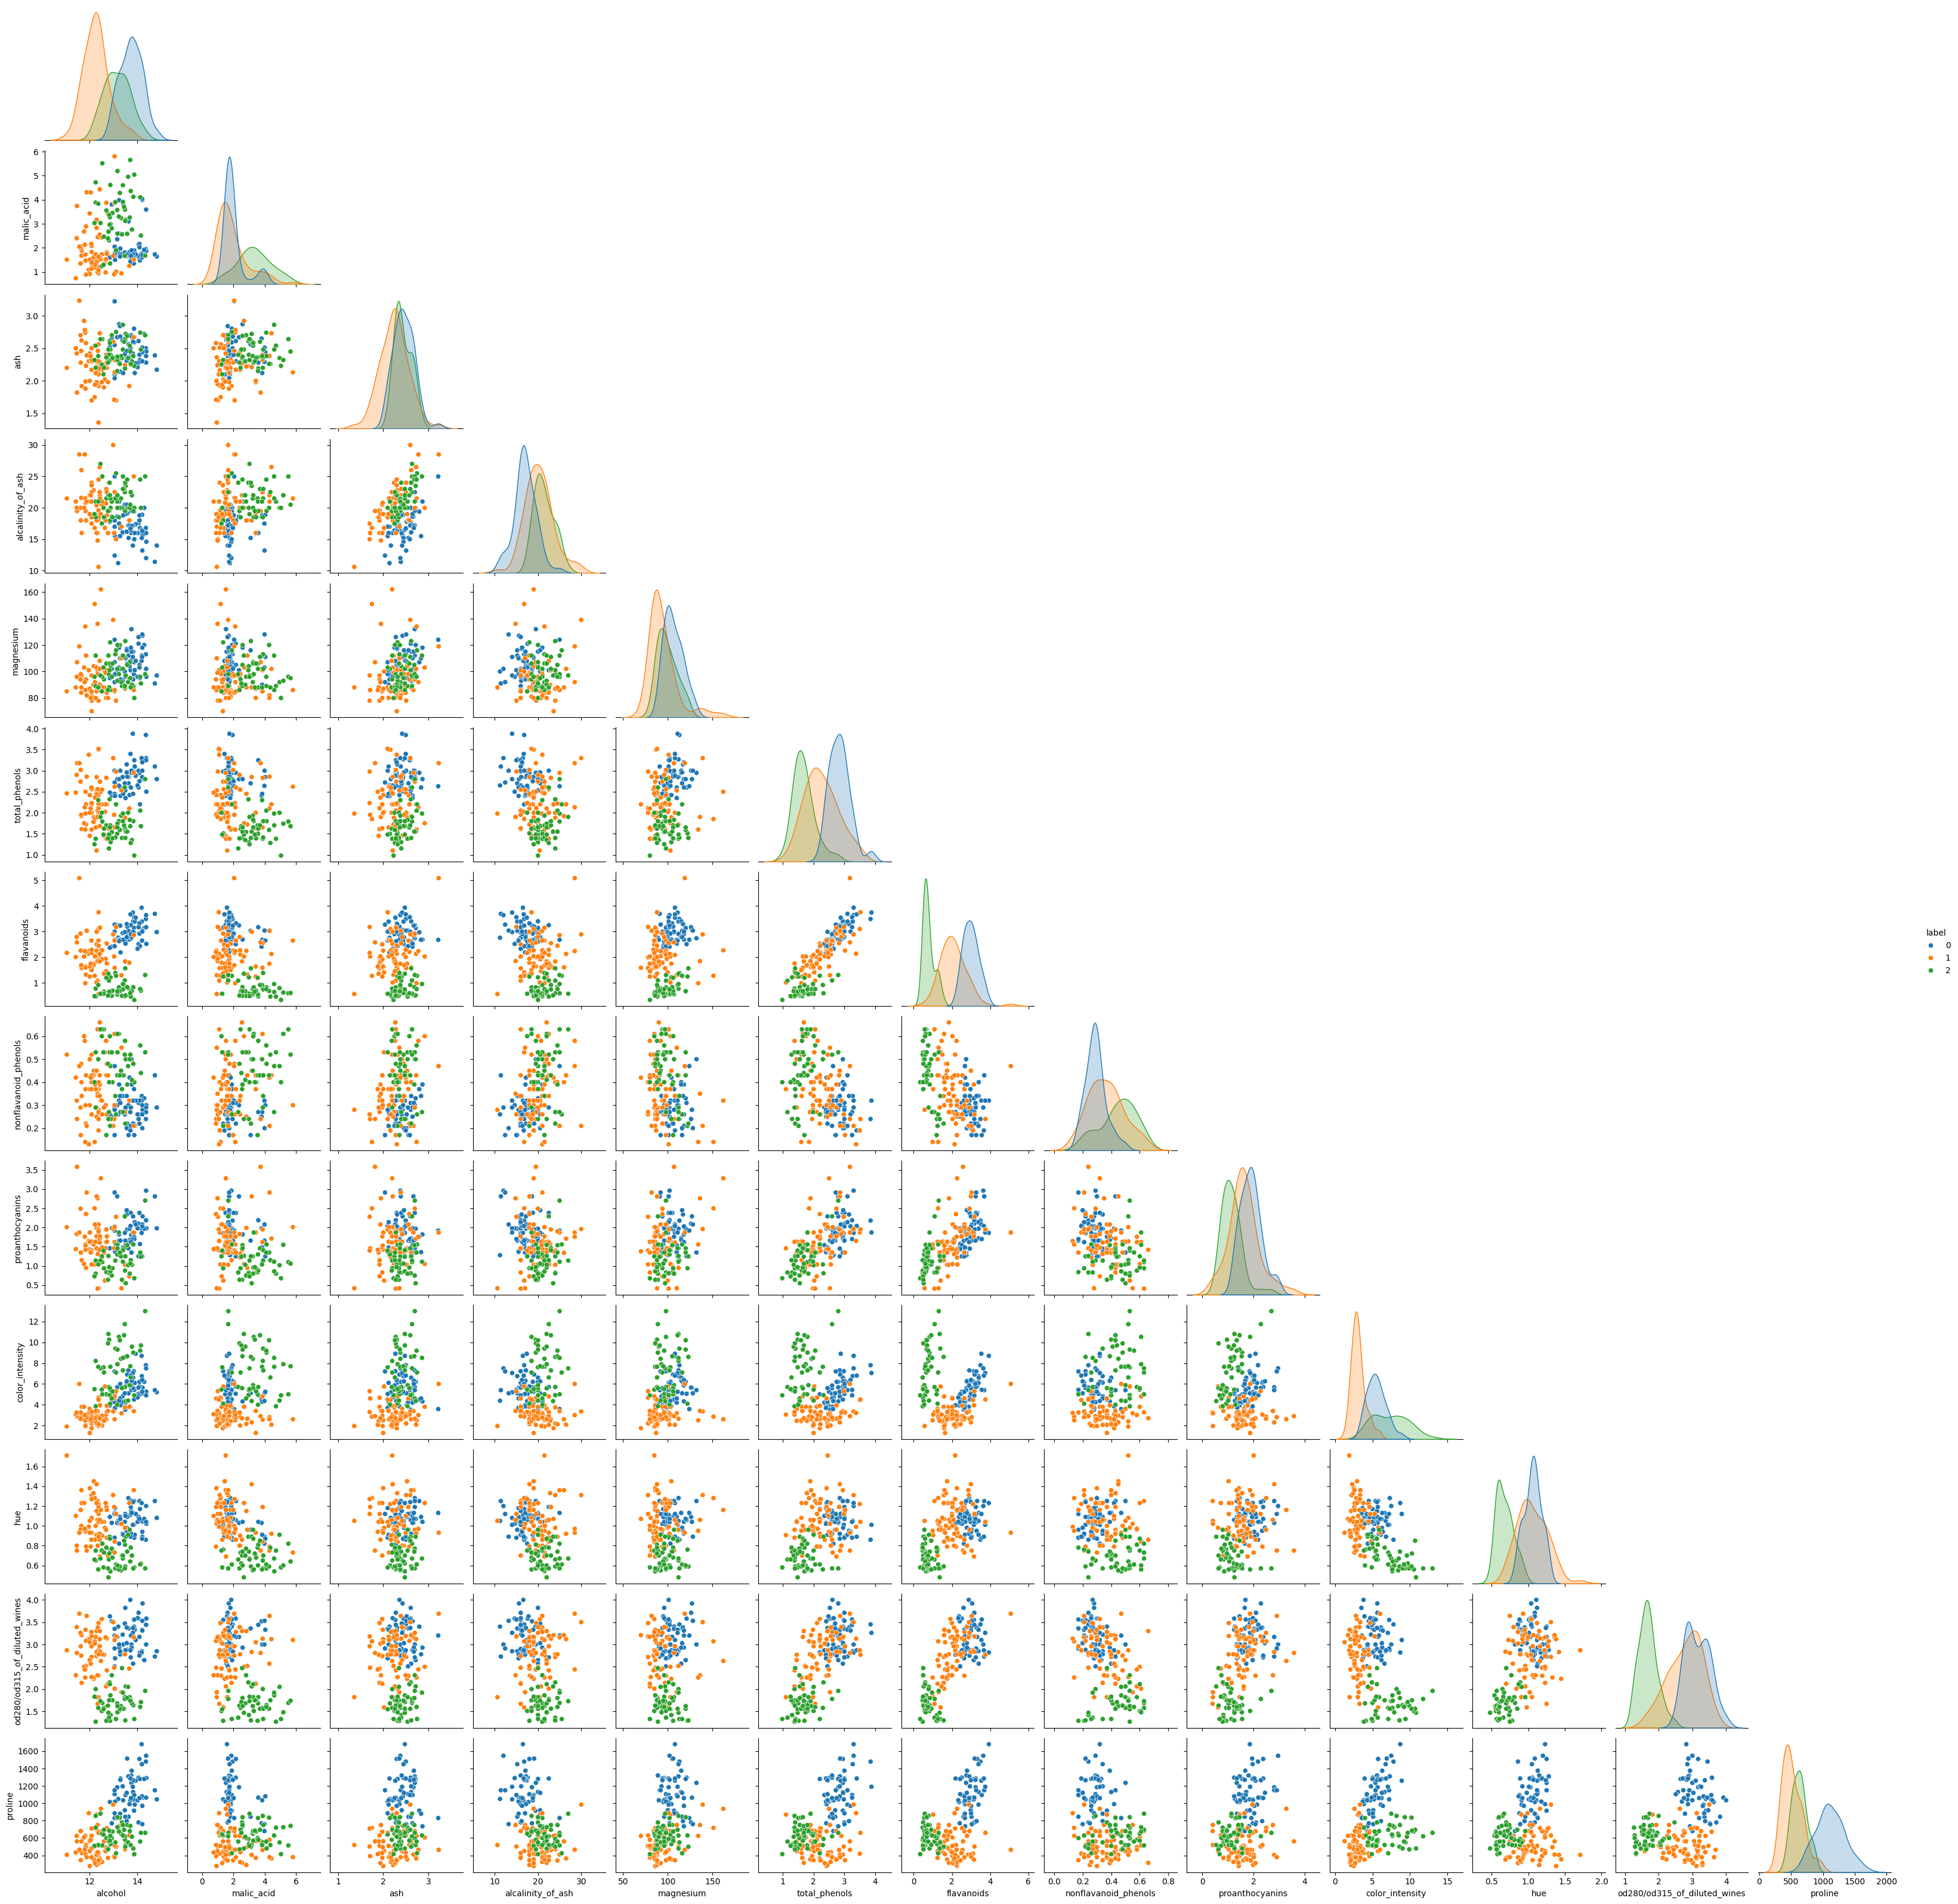

In [33]:
sns.pairplot(feature_df, 
             hue='label', 
             palette="tab10", 
             corner=True)

plt.show()

# Data Preparation/Feature engineering

total_phenols elimintaed due to high linear correlation with flavanoids

In [34]:
## Define your input data frame
feature_df=pd.DataFrame(data=wine_data.data, columns=wine_data.feature_names)
feature_df["label"]=data=wine_data.target
columns_to_use=['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [35]:
X=feature_df[columns_to_use]
y=feature_df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)


# Transform Data

In [36]:
encoder=LabelEncoder()
scaler=StandardScaler()

# encoding train labels 
encoder.fit(y_train)
y_train_transformed = encoder.transform(y_train)

# encoding test labels 
y_test_transformed = encoder.transform(y_test)

#scale train feature data frame
scaler.fit(X_train)
X_train_transform=scaler.transform(X_train)

#scale test feature data frame
X_test_transform=scaler.transform(X_test)

# MLflow application

In [37]:

def eval_metrics(actual, pred):
    "Evaluate classification model."
    
    precision = precision_score(actual, pred,  average='micro')
    recall = recall_score(actual, pred,  average='micro')
    f1 = f1_score(actual, pred,  average='micro')
    return precision, recall, f1

In [38]:
def calculate_save_classification_report(path, description, actual_test, predicted_test,figsize=(8,5)):
    plt.rc("figure", figsize=figsize)
    plt.text(
        0.01,
        1.25,
        str(f"{description} Test"),
        {"fontsize": 10},
        fontproperties="monospace",
    )
    plt.text(
        0.01,
        0.05,
        str(classification_report(actual_test, predicted_test)),
        {"fontsize": 10},
        fontproperties="monospace",
    )  # approach improved by OP -> monospace!
   
    plt.axis("off")
    plt.savefig(f"{path}/{description}_results.png")
    plt.close()


In [39]:
experiment_name="Wine data-Random Forest classification example"
try:
    experiment_id=mlflow.create_experiment(name=experiment_name)
except Exception as e:
    experiment_id=mlflow.get_experiment_by_name(experiment_name).experiment_id

In [58]:
image_path="plots"
if not os.path.exists(image_path):
        os.makedirs(image_path)

# define hyperperameters you want to test
max_depth=[5,10, 15,40]
numb_estimators=[5, 10, 15,50]
criteria=["entropy" ,"gini"]

for depth in max_depth:
        for estimators in numb_estimators:
                for criterion in criteria:
                        with mlflow.start_run(experiment_id=experiment_id):
                        
                                #mlflow tracking: track input parameters
                                mlflow.log_param('max_depth', depth)
                                mlflow.log_param('number_estimators', estimators)
                                mlflow.log_param('criterion',criterion)

                                #Do some EDA (add other plots of needed)
                                sns.heatmap(X_train.iloc[:,:-1].corr(), annot=True, cmap="YlGnBu")

                                #Save the plot
                                plt.savefig(f'{image_path}/heatmap.png')
                                plt.close()

                              
                                #define model
                                crf=RandomForestClassifier(random_state=42,n_estimators=estimators, criterion=criterion,max_depth=depth)

                                #train model
                                crf.fit(X_train_transform,y_train_transformed)

                                #make predictions
                                y_pred=crf.predict(X_test_transform)

                                #evaluate model
                                precision, recall, f1= eval_metrics(actual=y_test_transformed, pred=y_pred)

                                #make and save classification plot
                                calculate_save_classification_report(path=image_path, description="Classification Report ", actual_test=y_test_transformed, predicted_test=y_pred,figsize=(8,5))

                                #mlflow tracking: log metrics
                                mlflow.log_metric('precision', precision)
                                mlflow.log_metric('recall', recall)
                                mlflow.log_metric('f1',f1)

                                #mlflow tracking: log artifacts
                                mlflow.log_artifacts(image_path)

                                # model signature
                                signature = mlflow.models.infer_signature(X_train, y_pred)

                                #mlflow log model
                                mlflow.sklearn.log_model(crf,"RandomForestClassifier_Model", signature=signature)
                




# Exemplify custom model implementation 

In [40]:
# additional inputs needed just for this part
from mlflow.pyfunc import PythonModel
from interpret.glassbox import ExplainableBoostingClassifier

In [41]:
experiment_name="Wine data - EBM classification example"
try:
    experiment_id=mlflow.create_experiment(name=experiment_name)
except Exception as e:
    experiment_id=mlflow.get_experiment_by_name(experiment_name).experiment_id

In [42]:
conda_env = {
    'name': 'mlflow-env',
    'channels': ['defaults'],
    'dependencies': [
        'python=3.8.10',
        'scikit-learn',
        'pip',
        {
            'pip': [
                'mlflow',
                'interpret'
            ],
        },
    ],
}

In [43]:
class CustomEBM(PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self,context, model_input):
        return self.model.predict(model_input)


In [44]:
# Train ExplainableBoostingClassifier
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

# Log the model in MLflow
with mlflow.start_run(experiment_id=experiment_id) as run:
    # Wrap the trained EBM model
    ebm_wrapper = CustomEBM(ebm)

    ## predict using model wrapper
    y_pred=ebm.predict(X_test)

    ## eval metrics
    precision, recall, f1= eval_metrics(actual=y_test, pred=y_pred)

    ##log metrics
    #mlflow tracking: log metrics
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)
    mlflow.log_metric('f1',f1)
    

    # Log the model using the pyfunc flavor
    mlflow.pyfunc.log_model(
        artifact_path="ebm_model",
        python_model=ebm_wrapper,
        conda_env=conda_env
    )

2024/10/15 10:14:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


# Load and predict using a model

In [79]:
logged_model_uri = f"runs:/{run.info.run_id}/ebm_model"
loaded_model = mlflow.pyfunc.load_model(logged_model_uri)

# Predict using the loaded model
predictions = loaded_model.predict(X_test)
print(predictions)

[0 0 2 0 1 0 1 2 1 2 0 2 0 1 0 1 1 1 0 1 0 1 1 2 2 2 1 1 1 0 0 1 2 0 0 0 2
 2 1 2 0 1 1 1 2 0 1 1 2 0 1 0 0 2 2 1 1 0 1 0 2 1 1 2 0 0 0 2 0 0 1 2]


In [45]:
logged_model_uri = f"runs:/02ee0304a2d14c37a614438acb7d156d/RandomForestClassifier_Model"
loaded_model = mlflow.pyfunc.load_model(logged_model_uri)

# Predict using the loaded model
predictions = loaded_model.predict(X_test)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## If you pass a model signature ---> errors occur when wrong inputs are passed (see below)

In [46]:
##If we input wrong model input signature and Exception will be thrown!

logged_model_uri = f"runs:/02ee0304a2d14c37a614438acb7d156d/RandomForestClassifier_Model"
loaded_model = mlflow.pyfunc.load_model(logged_model_uri)

# Predict using the loaded model
X_test_wrong=X_test.rename(columns={"alcohol":"alcohols"})
predictions = loaded_model.predict(X_test_wrong)
print(predictions)

MlflowException: Failed to enforce schema of data '     alcohols  malic_acid   ash  alcalinity_of_ash  magnesium  flavanoids  \
19      13.64        3.10  2.56               15.2      116.0        3.03   
45      14.21        4.04  2.44               18.9      111.0        2.65   
140     12.93        2.81  2.70               21.0       96.0        0.50   
30      13.73        1.50  2.70               22.5      101.0        3.25   
67      12.37        1.17  1.92               19.6       78.0        2.00   
..        ...         ...   ...                ...        ...         ...   
144     12.25        3.88  2.20               18.5      112.0        0.78   
4       13.24        2.59  2.87               21.0      118.0        2.69   
32      13.68        1.83  2.36               17.2      104.0        2.69   
95      12.47        1.52  2.20               19.0      162.0        2.27   
170     12.20        3.03  2.32               19.0       96.0        0.49   

     nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
19                   0.17             1.66             5.10  0.96   
45                   0.30             1.25             5.24  0.87   
140                  0.53             0.75             4.60  0.77   
30                   0.29             2.38             5.70  1.19   
67                   0.27             1.04             4.68  1.12   
..                    ...              ...              ...   ...   
144                  0.29             1.14             8.21  0.65   
4                    0.39             1.82             4.32  1.04   
32                   0.42             1.97             3.84  1.23   
95                   0.32             3.28             2.60  1.16   
170                  0.40             0.73             5.50  0.66   

     od280/od315_of_diluted_wines  proline  
19                           3.36    845.0  
45                           3.33   1080.0  
140                          2.31    600.0  
30                           2.71   1285.0  
67                           3.48    510.0  
..                            ...      ...  
144                          2.00    855.0  
4                            2.93    735.0  
32                           2.87    990.0  
95                           2.63    937.0  
170                          1.83    510.0  

[72 rows x 12 columns]' with schema '['alcohol': double (required), 'malic_acid': double (required), 'ash': double (required), 'alcalinity_of_ash': double (required), 'magnesium': double (required), 'flavanoids': double (required), 'nonflavanoid_phenols': double (required), 'proanthocyanins': double (required), 'color_intensity': double (required), 'hue': double (required), 'od280/od315_of_diluted_wines': double (required), 'proline': double (required)]'. Error: Model is missing inputs ['alcohol']. Note that there were extra inputs: ['alcohols']

# Get model details in Python

In [87]:
client=mlflow.tracking.MlflowClient()
client.get_run("02ee0304a2d14c37a614438acb7d156d")

<Run: data=<RunData: metrics={'f1': 0.9583333333333334,
 'precision': 0.9583333333333334,
 'recall': 0.9583333333333334}, params={'criterion': 'entropy', 'max_depth': '10', 'number_estimators': '10'}, tags={'mlflow.log-model.history': '[{"run_id": "02ee0304a2d14c37a614438acb7d156d", '
                             '"artifact_path": "RandomForestClassifier_Model", '
                             '"utc_time_created": "2024-10-11 '
                             '14:58:02.767947", "model_uuid": '
                             '"b031f2d5fec84d0da5c948e15c94087c", "flavors": '
                             '{"python_function": {"model_path": "model.pkl", '
                             '"predict_fn": "predict", "loader_module": '
                             '"mlflow.sklearn", "python_version": "3.8.20", '
                             '"env": {"conda": "conda.yaml", "virtualenv": '
                             '"python_env.yaml"}}, "sklearn": '
                             '{"pickled_model": "mode

# Serve model

#use command in terminal!
mlflow models serve --model-uri mlruns/502254586279645852/02ee0304a2d14c37a614438acb7d156d/artifacts/RandomForestClassifier_Model -p 5600

In [20]:
import requests
import json

# Define the URL of the model serving
url = "http://127.0.0.1:5600/invocations"

# Prepare the input data
data ={ "dataframe_records":  
       [{'alcohol': 14.2,
        'malic_acid': 1.76,
        'ash': 2.45,
        'alcalinity_of_ash': 15.2,
        'magnesium': 112.0,
        'total_phenols': 3.27,
        'flavanoids': 3.39,
        'nonflavanoid_phenols': 0.34,
        'proanthocyanins': 1.97,
        'color_intensity': 6.75,
        'hue': 1.05,
        'od280/od315_of_diluted_wines': 2.85,
        'proline': 1450.0,
        'label': 0.0} ]
 }


# Convert the input data to JSON
json_data = json.dumps(data)

# Set the content type to application/json
headers = {"Content-Type": "application/json"}

# Make the POST request
response = requests.post(url, data=json_data, headers=headers)

# Print the response from the model
print("Status Code:", response.status_code)
print("Response:", response.json())

Status Code: 200
Response: {'predictions': [0]}


# Query Runs using MLflow APIs

In [26]:
runs_df = mlflow.search_runs(
    experiment_names=["Wine data-Random Forest classification example"],
   # filter_string="metrics.f1 > 0.96"
)

In [28]:
runs_df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.recall,metrics.precision,metrics.f1,params.number_estimators,params.max_depth,params.criterion,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type
0,f08392eab34a4e41837d695d2843f791,502254586279645852,FINISHED,file:///Users/danielamorariu/Documents/MLflow_...,2024-10-11 14:58:57.715000+00:00,2024-10-11 14:59:00.319000+00:00,1.000000,1.000000,1.000000,50,40,gini,"[{""run_id"": ""f08392eab34a4e41837d695d2843f791""...",danielamorariu,languid-eel-241,/Users/danielamorariu/opt/anaconda3/envs/mlflo...,LOCAL
1,fd7636ccdf6b4c3c8244dc177c6337bb,502254586279645852,FINISHED,file:///Users/danielamorariu/Documents/MLflow_...,2024-10-11 14:58:55.334000+00:00,2024-10-11 14:58:57.711000+00:00,1.000000,1.000000,1.000000,50,40,entropy,"[{""run_id"": ""fd7636ccdf6b4c3c8244dc177c6337bb""...",danielamorariu,suave-fish-611,/Users/danielamorariu/opt/anaconda3/envs/mlflo...,LOCAL
2,da1277ca46c5463abbfa417f91a9ef73,502254586279645852,FINISHED,file:///Users/danielamorariu/Documents/MLflow_...,2024-10-11 14:58:52.798000+00:00,2024-10-11 14:58:55.330000+00:00,0.972222,0.972222,0.972222,15,40,gini,"[{""run_id"": ""da1277ca46c5463abbfa417f91a9ef73""...",danielamorariu,carefree-conch-309,/Users/danielamorariu/opt/anaconda3/envs/mlflo...,LOCAL
3,26b55238d0af40069a4155b232bc72b7,502254586279645852,FINISHED,file:///Users/danielamorariu/Documents/MLflow_...,2024-10-11 14:58:50.419000+00:00,2024-10-11 14:58:52.795000+00:00,0.972222,0.972222,0.972222,15,40,entropy,"[{""run_id"": ""26b55238d0af40069a4155b232bc72b7""...",danielamorariu,bedecked-smelt-147,/Users/danielamorariu/opt/anaconda3/envs/mlflo...,LOCAL
4,7322480d02934cc5b7939ea651c47152,502254586279645852,FINISHED,file:///Users/danielamorariu/Documents/MLflow_...,2024-10-11 14:58:47.883000+00:00,2024-10-11 14:58:50.416000+00:00,0.972222,0.972222,0.972222,10,40,gini,"[{""run_id"": ""7322480d02934cc5b7939ea651c47152""...",danielamorariu,clumsy-donkey-407,/Users/danielamorariu/opt/anaconda3/envs/mlflo...,LOCAL
